Design of Autonomous and Semi-Autonomous Agentic Workflows Project

Name: Sabrina Palis

Repository: https://github.com/MinervaRose/design-of-agentic-workflows


# **0. Environment Setup**

This notebook is designed to run in Google Colab. It assumes access to:

- Python 3.x
- OpenAI API credentials
- standard scientific Python libraries

All environment setup steps are included below to ensure reproducibility.

## 0.1 Drive mount

In [1]:
# Optional: Google Colab setup
# Uncomment only if running in Google Colab and using Google Drive storage
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Go to directory
# %cd /content/drive/MyDrive/Capstone/agentic-ai-systems/

/content/drive/MyDrive/Capstone/agentic-ai-systems


## 0.2 Imports

In [3]:
import os
import json
import uuid
from dataclasses import dataclass
from typing import List, Literal, Optional

## 0.3 OpenAI API setup

In [4]:
import os
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

#**1. Defining the Agentic Task and System Scope**

## 1.1 Agentic task goal

Build a **small-scale Aerospace Anomaly Triage Agent** that supports monitoring of aerospace-like sensor streams by triaging incident reports into one of three outcomes - Normal, Suspicious, or Critical - and recommending a safe next action (e.g., request additional data, monitor, or escalate to a human operator). The system is designed as a **decision-support agent**, not an autonomous controller: it does not execute real-world actions and does not interface with real mission systems.

## 1.2 Single-agent or multi-agent

This project uses a **single-agent** workflow. A single agent is appropriate because the task is narrowly scoped to one decision owner: interpreting an incoming incident report, consulting tools/state, and producing a triage decision with an explanation. Using multiple agents would add coordination complexity without improving performance for this bounded task.

## 1.3 Decisions the agent is responsible for

For each incoming incident report, the agent is responsible for making and documenting the following decisions:

1.   **Data sufficiency check**

Determine whether required fields are present and plausible (e.g., non-null values, valid ranges). If not, the agent must choose a safe fallback (typically escalation or request-more-info).

2.   **Risk/Anomaly classification**

Use tool outputs (e.g., anomaly score, rule flags) and recent context (limited memory) to classify the incident as:

   * Normal: expected variation, no immediate action

   * Suspicious: requires additional monitoring or data

   * Critical: requires escalation to a human operator

3.   **Confidence and uncertainty handling**

Estimate confidence in the decision. If confidence is below a defined threshold or if tool outputs conflict, the agent must follow a safeguard policy (e.g., escalate rather than over-commit).

4.   **Next-action recommendation**

Select a bounded, allowed action from a predefined set (monitor, request more data, escalate), and provide a short rationale grounded in tool outputs and/or recent incident history.

## 1.4 Actions/tools the agent can use

The agent can invoke a small set of course-style tools (implemented as Python functions) to support its decisions:

*    ```score_incident_tool(report)```

Returns an anomaly/risk score and flags (e.g., packet loss high, drift detected), plus a “confidence hint” based on data completeness.

*    ```get_sensor_history_tool(sensor_id, n=K)```

Retrieves recent incidents/decisions for that sensor from an in-memory event log to support trend-based reasoning (limited memory/state).

*    ```run_evals_tool(report, proposed_decision, tool_outputs)```

Checks the decision against explicit criteria (e.g., “if missing critical fields → must escalate”, “if score ≥ threshold → cannot label Normal”). Produces pass/fail feedback and reasons.

*   ```final_answer_tool(decision_object)```

Signals termination of the workflow and outputs a structured final decision (e.g., a Pydantic model or JSON object).

*(Optional, if we want a controlled interaction loop):*

*   ```request_more_info_tool(missing_fields)```

simulates requesting additional measurements; used only when the agent detects insufficient data and the policy allows a retry.

* **LLM synthesis interface (OpenAI API)**

Generates a structured triage decision from deterministic tool outputs. The LLM is constrained by evaluation rules and safeguards, and does not override deterministic safety checks.

## 1.5 Scope boundaries and constraints

* The system operates on **simulated or synthetic incident reports** for reproducible testing and does not connect to real operational aerospace systems.

* The agent is **decision-support only**: it can recommend escalation but does not autonomously trigger real-world actions.

* The agent follows explicit **safeguard policies**: missing data, low confidence, or conflicting tool signals must result in escalation or a request for more information rather than confident guessing.

* The workflow is **intentionally small-scale**: short tool-use loops and limited memory to demonstrate agentic orchestration clearly and reliably.

## 1.6 Why an agentic approach is appropriate

This task benefits from an agentic workflow because the solution requires multi-step reasoning (check data quality → consult tools → incorporate recent context → decide → self-evaluate → revise or finalize) rather than a single one-shot prediction. Tool use improves reliability (e.g., deterministic scoring and retrieval), while limited memory enables context-aware decisions (trend detection), and safeguards prevent unsafe overconfidence.

An LLM is used to synthesize structured decisions from tool outputs, while deterministic evaluation and safeguards ensure reliability and prevent unsafe autonomy.

## 1.7 Implementation and originality notes

* The system will be implemented in Python (Colab) using agentic orchestration patterns covered in the coursework, including tool-calling workflows and controlled LLM synthesis via the OpenAI API.

* The incident environment is simulated for academic safety and reproducibility, with tools representing external interactions (diagnostics scoring and history retrieval).

* This agent/workflow is original to P7 and is not reused from any previous capstone project.

---

# **2. Agent Architecture and Workflow Design**

## 2.1 Core components

### **Persona (agent role)**

**Role:** Aerospace Anomaly Triage Agent

**Mission:** Triage simulated aerospace sensor incident reports into Normal / Suspicious / Critical, recommend a bounded next action (monitor / request-more-info / escalate), and document decisions transparently.

**Boundaries:** Decision-support only. The agent does not control real systems, and it escalates uncertainty instead of guessing.

### **Reasoning loop (workflow logic)**

The agent follows a short, inspectable loop inspired by tool-using agent patterns:

1.   **Ingest & validate:** Parse the incoming ```IncidentReport``` (schema validation + plausibility checks).

2.   **Diagnose via tools:** Call ```score_incident_tool(report)``` to obtain a risk score, flags, and confidence hints.

3.   **Context check (memory):** Call ```get_sensor_history_tool(sensor_id, n=K)``` and use recent trends to adjust confidence/decision.

4.   **Decide:** Produce a structured ```TriageDecision``` (classification, confidence, rationale, next action).

5.  **Evaluate:** Call ```run_evals_tool(...)``` to check decision quality against explicit criteria.

6.   **Revise or finalize:**

   * If eval fails and revision budget remains, revise the decision (optionally calling tools again).

   * Otherwise, finalize using ```final_answer_tool(decision)```.


### **Memory / state**

The system uses **limited, explicit memory** to support trend-aware decisions:

* **Event log:** append-only store of past incident reports and triage outcomes (used for retrieval).

* **Per-sensor recent window:** last K incidents for a sensor (used to detect escalation-worthy patterns).

* **Run state:** a small state object for the current run (tool outputs, eval results, revision count).

### **Tools (external capability via functions)**

The agent can invoke:

* ```score_incident_tool(report)``` → deterministic risk score + flags + confidence hint

* ```get_sensor_history_tool(sensor_id, n=K)``` → retrieve recent incidents/decisions

* ```run_evals_tool(report, proposed_decision, tool_outputs)``` → pass/fail criteria + feedback

* ```final_answer_tool(decision_object)``` → stops loop and returns structured output

* *(Optional)* ```request_more_info_tool(missing_fields)``` → simulates additional measurements if allowed

* **LLM Interface (OpenAI API):** used to generate or revise a structured ```TriageDecision``` only after deterministic tools provide scores/flags/history, and subject to rule-based evaluation and safeguards.

### **Safeguards (reliability + control)**

* **Missing-data safeguard:** if required fields are absent/invalid → escalate or request more info (never guess).

* **Uncertainty safeguard:** if confidence below threshold or tool outputs conflict → escalate.

* **Loop safeguard** max revision steps (e.g., 2) to prevent runaway behavior.

* **Transparency:** structured logs of tool calls, key thresholds, and reasons for escalation.



## 2.2 Architecture diagram (Mermaid)

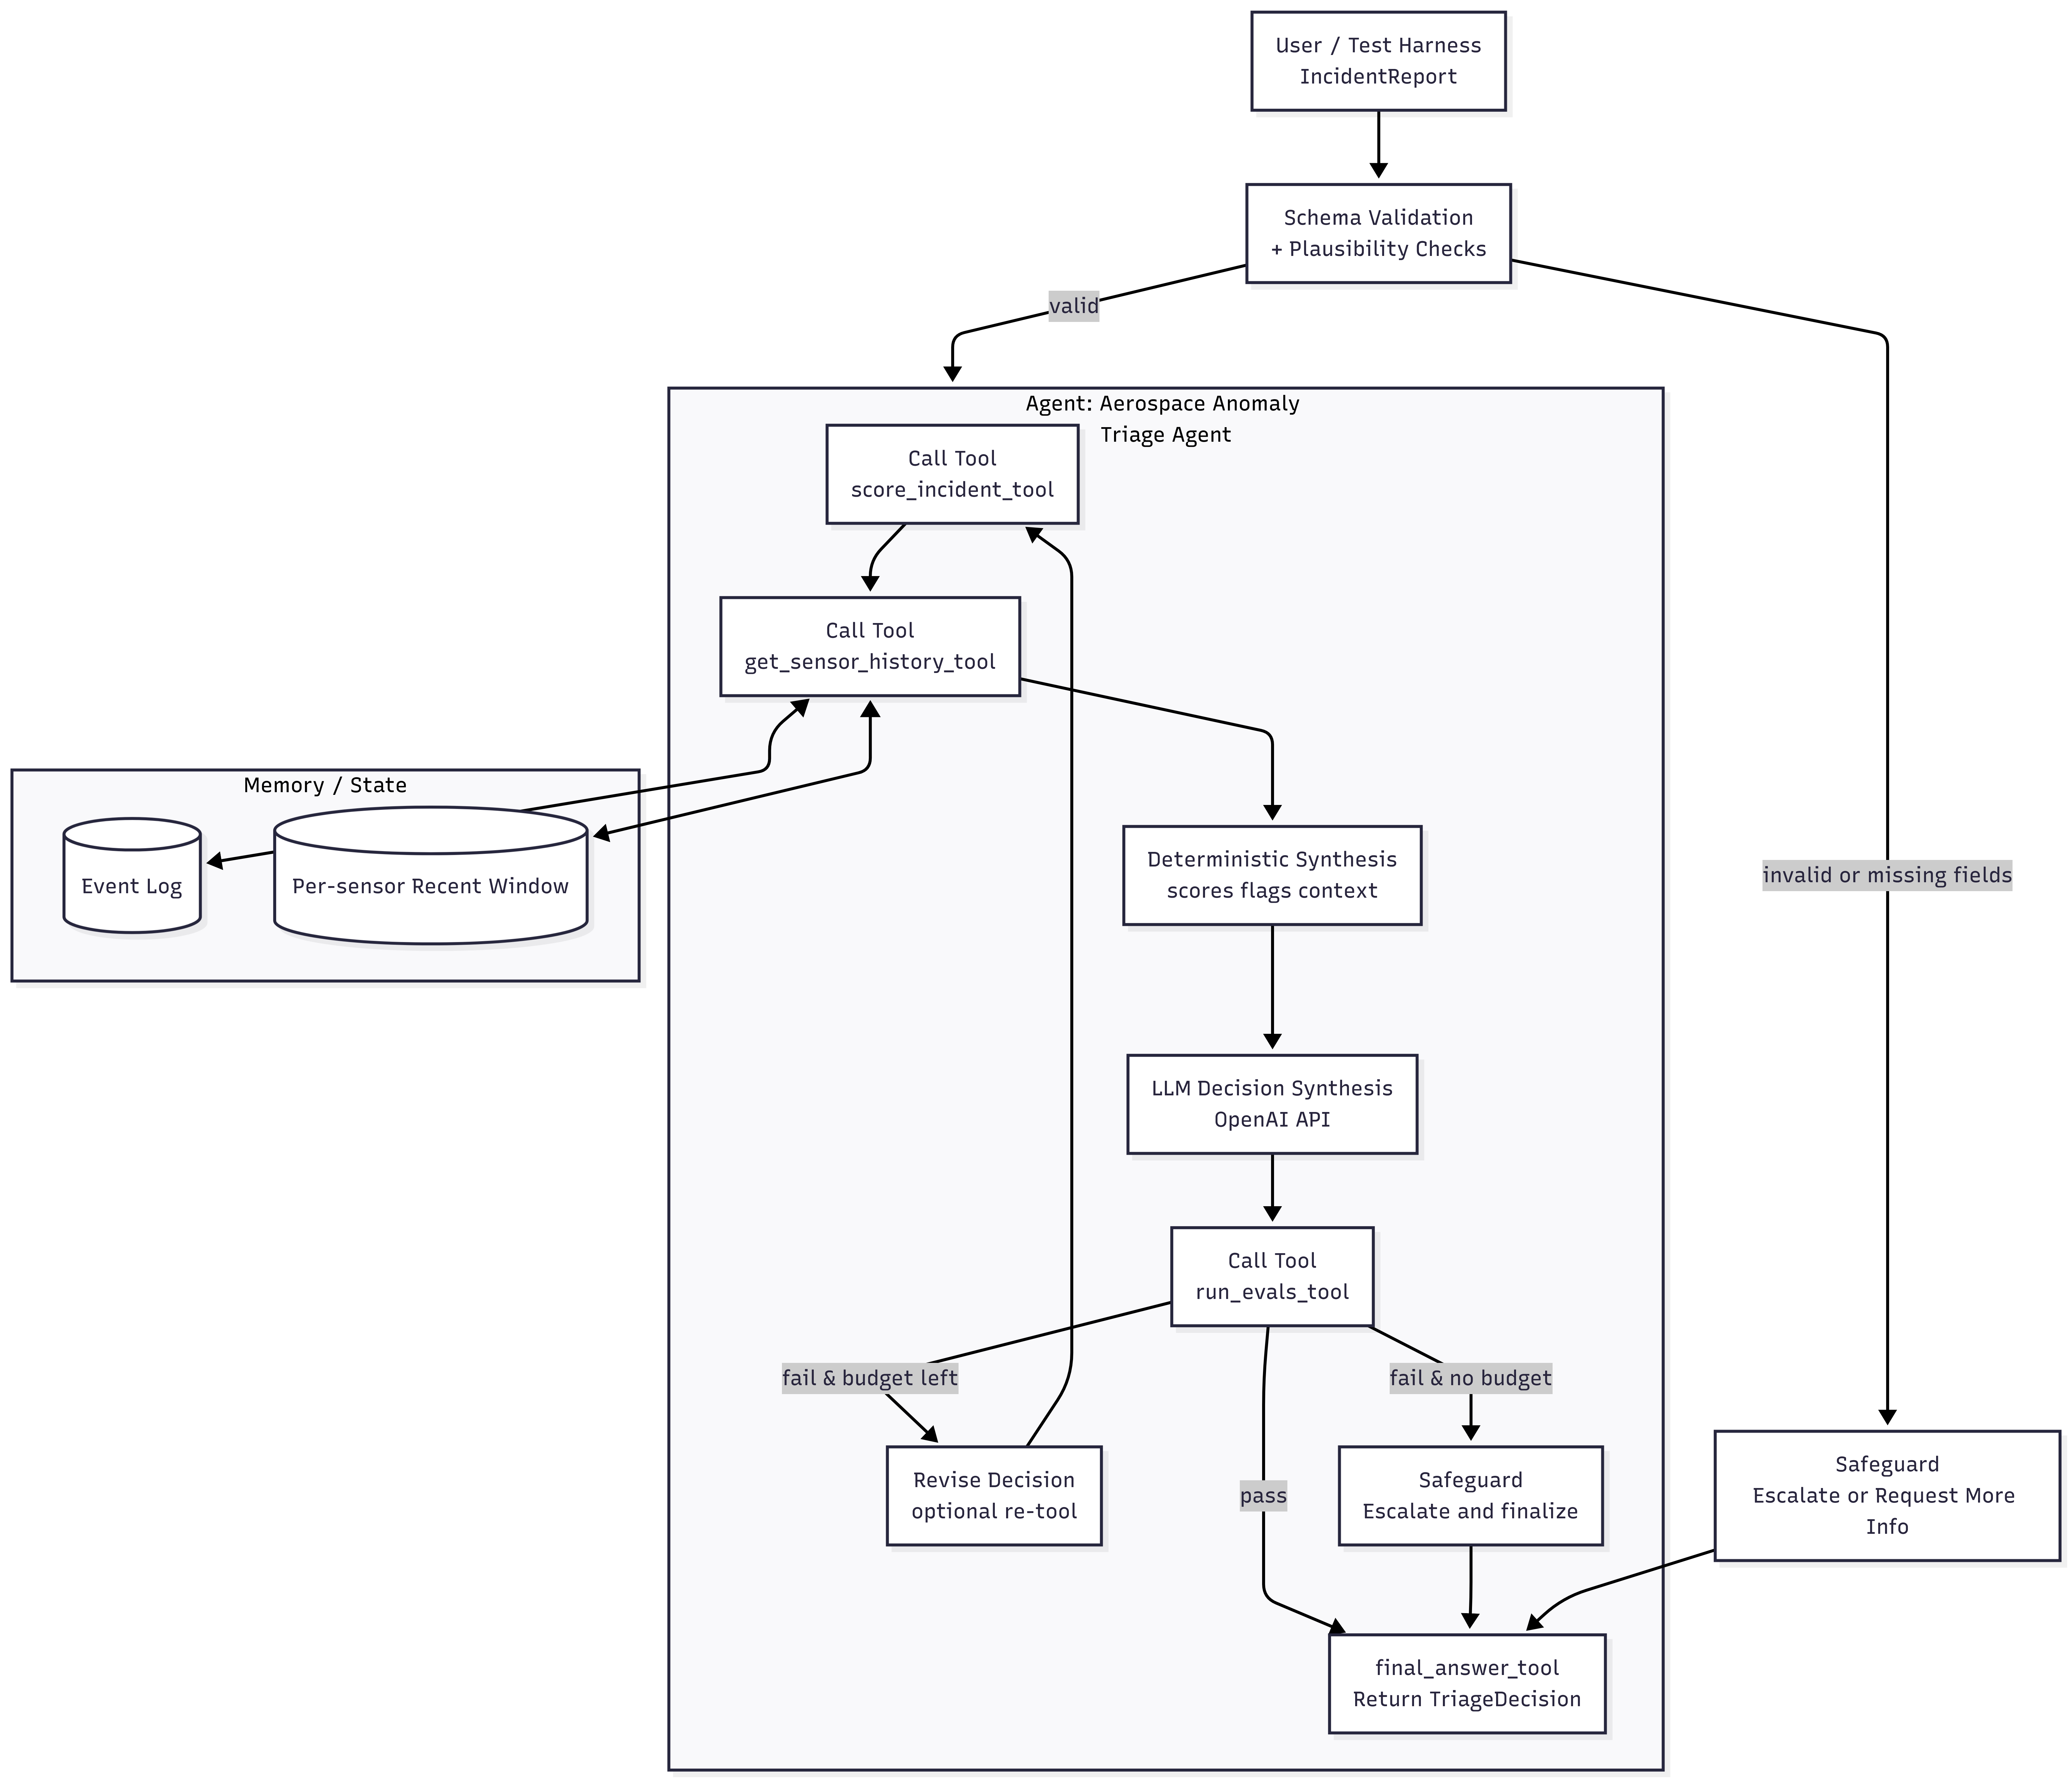

*Figure: Architecture of the Aerospace Anomaly Triage Agent showing tool orchestration, memory, safeguards, and bounded revision loop.*

In [5]:
# The diagram was created in Mermaid. The .png file was saved in the same folder as the notebook.
from IPython.display import Image, display, Markdown

display(Image("mermaid-chart.png"))
display(Markdown(
    "*Figure: Architecture of the Aerospace Anomaly Triage Agent showing tool orchestration, memory, safeguards, and bounded revision loop.*"
))


## 2.3 Design choices and tradeoffs

* **Single-agent vs multi-agent:** Single-agent keeps the system understandable and easier to evaluate. The task has one decision owner; multi-agent coordination would add complexity without clear benefit.

* **Deterministic tools + evaluation:** Scoring and evaluation are implemented as deterministic functions to reduce hallucinations and improve reproducibility. The LLM focuses on reasoning/explanation rather than hidden “magic.”

* **Limited memory:** Memory is intentionally simple (event log + recent window) to make state behavior observable and to avoid heavy infrastructure (vector DB, external storage) that is unnecessary for this project.

* **Revision budget:** A small revision loop provides an “agentic” correction mechanism while preventing unbounded ReAct loops. If evaluation cannot be satisfied, the system escalates instead of overfitting the answer.

* **Safety-first escalation:** Because this is a decision-support system, the safe fallback is escalation when uncertainty is high or data is insufficient.

## 2.4 Interfaces and data contracts

To keep the workflow transparent and reproducible, the agent operates on **explicit structured schemas**. Two core interfaces define the contract between components:

### **IncidentReport (input schema)**

Represents a simulated aerospace sensor incident. This structure ensures the agent always reasons over well-defined fields.

#### **Key fields:**

* ```incident_id: str```
Unique identifier for traceability and logging

* ```sensor_id: str```
Identifier of the sensor generating the report

* ```timestamp: str```
ISO-formatted time of the incident

* ```mission_phase: str```
Context label (e.g., launch, cruise, landing, test)

* ```snr: float | None```
Signal-to-noise ratio

* ```packet_loss: float | None```
Communication packet loss rate

* ```drift_rate: float | None```
Sensor drift magnitude

* ```temp_delta: float | None```
Temperature deviation from baseline

* ```operator_notes: str | None```
Optional human annotation

These fields intentionally allow missing values so the agent must reason about data sufficiency and trigger safeguards when appropriate.

### **TriageDecision (output schema)**

Represents the final structured decision returned by the agent.

#### **Key fields:**

* ```incident_id: str```
Links the decision to the original report

* ```classification: Literal["Normal", "Suspicious", "Critical"]```
Final risk category

* ```confidence: float```
Agent-estimated confidence (0–1)

* ```recommended_action: Literal["Monitor", "RequestMoreInfo", "Escalate"]```
Bounded action set

* ```rationale: str```
Human-readable explanation grounded in tool outputs

* ```safeguard_triggered: bool```
Whether escalation or fallback logic was activated

* ```trace_summary: str```
Short summary of tool calls and reasoning steps

### **Why structured interfaces matter**

Using explicit schemas:

* enforces consistent reasoning inputs

* prevents ambiguous agent outputs

* supports evaluation tooling

* improves transparency and debugging

* aligns with professional AI system design practices

This interface layer separates decision logic from data representation, making the architecture modular and inspectable.

---

# **3. Implementation**



## 3.1 Imports + OpenAI setup

In [6]:
import os
import json
import uuid
from dataclasses import dataclass
from typing import List, Literal, Optional

from openai import OpenAI

client = OpenAI()

## 3.2 Model configuration

In [7]:
from enum import Enum

class OpenAIModel(str, Enum):
    GPT_41 = "gpt-4.1"
    GPT_41_MINI = "gpt-4.1-mini"

MODEL = OpenAIModel.GPT_41_MINI

## 3.3 Configuration constants

In [8]:
MAX_REVISION_STEPS = 2
CONFIDENCE_THRESHOLD = 0.6
HISTORY_WINDOW = 5

## 3.4 Data schemas

In [9]:
@dataclass
class IncidentReport:
    incident_id: str
    sensor_id: str
    timestamp: str
    mission_phase: str
    snr: Optional[float]
    packet_loss: Optional[float]
    drift_rate: Optional[float]
    temp_delta: Optional[float]
    operator_notes: Optional[str] = None


@dataclass
class TriageDecision:
    incident_id: str
    classification: Literal["Normal", "Suspicious", "Critical"]
    confidence: float
    recommended_action: Literal["Monitor", "RequestMoreInfo", "Escalate"]
    rationale: str
    safeguard_triggered: bool
    trace_summary: str

## 3.5 Memory layer

In [10]:
event_log: List[TriageDecision] = []
sensor_history = {}

## 3.6 Deterministic tools

In [11]:
def score_incident_tool(report: IncidentReport):
    score = 0
    flags = []

    if report.packet_loss and report.packet_loss > 0.3:
        score += 0.4
        flags.append("packet_loss_high")

    if report.drift_rate and report.drift_rate > 0.5:
        score += 0.3
        flags.append("drift_detected")

    if report.temp_delta and abs(report.temp_delta) > 10:
        score += 0.3
        flags.append("temperature_anomaly")

    confidence_hint = 1.0 if None not in [
        report.snr, report.packet_loss, report.drift_rate, report.temp_delta
    ] else 0.5

    return score, flags, confidence_hint


def get_sensor_history_tool(sensor_id: str):
    return sensor_history.get(sensor_id, [])[-HISTORY_WINDOW:]

## 3.7 LLM interface

In [22]:
def llm_decision_synthesis(report, score, flags, history, feedback: str | None = None):

    system_prompt = """
You are an aerospace safety triage agent.
You must output ONLY valid JSON matching this schema:

{
 "classification": "Normal | Suspicious | Critical",
 "confidence": float,
 "recommended_action": "Monitor | RequestMoreInfo | Escalate",
 "rationale": string
}

Rules:
- The anomaly score is on a 0–1 scale. 1.0 is maximum risk. 0.0 is minimum.
- If score >= 0.7, classification MUST be "Critical".
- Never invent data.
"""

    user_prompt = f"""
Anomaly score: {score}  (scale 0 to 1, higher means higher risk)
Flags: {flags}
Recent history: {history}
"""

    if feedback:
        user_prompt += f"\nEVALUATION FEEDBACK: {feedback}\nPlease revise your JSON to satisfy this feedback."

    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format={"type": "json_object"}
    )

    return json.loads(response.choices[0].message.content)

## 3.8 Evaluation tool

In [23]:
def run_evals_tool(score: float, flags: list, decision: dict):
    classification = decision["classification"]
    action = decision["recommended_action"]
    confidence = decision["confidence"]

    # Consistency rules
    if score >= 0.7 and classification != "Critical":
        return False, "score>=0.7 must be Critical"

    if 0.3 <= score < 0.7 and classification == "Normal":
        return False, "0.3<=score<0.7 cannot be Normal"

    # Safety rules
    severe_flags = {"packet_loss_high", "drift_detected", "temperature_anomaly"}
    if len(severe_flags.intersection(set(flags))) >= 2 and action == "Monitor":
        return False, ">=2 severe flags cannot be Monitor-only"

    # Confidence sanity
    if not (0.0 <= confidence <= 1.0):
        return False, "confidence must be between 0 and 1"

    return True, "pass"

## 3.9 Safeguard check

In [24]:
def safeguard_missing_data(report: IncidentReport):
    required = [report.snr, report.packet_loss, report.drift_rate, report.temp_delta]
    return any(v is None for v in required)

## 3.10 Agent class

In [33]:
class AerospaceTriageAgent:

    def run(self, report: IncidentReport):

        if safeguard_missing_data(report):
            return TriageDecision(
                report.incident_id,
                "Suspicious",
                0.0,
                "RequestMoreInfo",
                "Missing critical data",
                True,
                "missing-data safeguard"
            )

        revision_steps = 0
        feedback = None
        revision_log = []

        while revision_steps <= MAX_REVISION_STEPS:

            score, flags, conf_hint = score_incident_tool(report)
            history = get_sensor_history_tool(report.sensor_id)

            llm_output = llm_decision_synthesis(
                report, score, flags, history, feedback
            )

            valid, reason = run_evals_tool(score, flags, llm_output)

            if valid:
                break

            revision_log.append(reason)
            feedback = reason
            revision_steps += 1

        safeguard = revision_steps > MAX_REVISION_STEPS

        trace = {
            "score": score,
            "flags": flags,
            "revisions": revision_steps,
            "revision_log": revision_log
        }

        decision = TriageDecision(
            report.incident_id,
            llm_output["classification"],
            llm_output["confidence"],
            "Escalate" if safeguard else llm_output["recommended_action"],
            llm_output["rationale"],
            safeguard,
            json.dumps(trace)
        )

        event_log.append(decision)
        sensor_history.setdefault(report.sensor_id, []).append(decision)

        return decision

## 3.11 Quick test: single incident run

In [35]:
agent = AerospaceTriageAgent()

test_report = IncidentReport(
    incident_id=str(uuid.uuid4()),
    sensor_id="S-001",
    timestamp="2026-02-15T10:00:00Z",
    mission_phase="cruise",
    snr=0.8,
    packet_loss=0.5,
    drift_rate=0.7,
    temp_delta=15,
)

decision = agent.run(test_report)
decision

TriageDecision(incident_id='5b4189e8-80f9-47b7-b627-d3c4940d3819', classification='Critical', confidence=1.0, recommended_action='Escalate', rationale='The anomaly score is at the maximum of 1.0, indicating a high risk. Multiple flags including packet_loss_high, drift_detected, and temperature_anomaly confirm significant operational concerns. Previous similar incidents with the same score and flags have been consistently classified as Critical and required escalation to promptly address potential safety threats.', safeguard_triggered=False, trace_summary='{"score": 1.0, "flags": ["packet_loss_high", "drift_detected", "temperature_anomaly"], "revisions": 0, "revision_log": []}')

---
# **4. Executing and Observing Agent Behavior**

## 4.1 Creating representative test scenarios

In [36]:
def make_report(
    sensor_id: str,
    mission_phase: str,
    snr: Optional[float],
    packet_loss: Optional[float],
    drift_rate: Optional[float],
    temp_delta: Optional[float],
    notes: Optional[str] = None,
    timestamp: str = "2026-02-15T10:00:00Z",
):
    return IncidentReport(
        incident_id=str(uuid.uuid4()),
        sensor_id=sensor_id,
        timestamp=timestamp,
        mission_phase=mission_phase,
        snr=snr,
        packet_loss=packet_loss,
        drift_rate=drift_rate,
        temp_delta=temp_delta,
        operator_notes=notes
    )

scenarios = [
    ("Normal_low_risk", make_report("S-100", "cruise", 0.9, 0.05, 0.05, 1.0, "All nominal.")),
    ("Suspicious_packet_loss", make_report("S-101", "cruise", 0.8, 0.35, 0.05, 1.0, "Intermittent dropouts observed.")),
    ("Suspicious_drift", make_report("S-102", "cruise", 0.7, 0.10, 0.65, 2.0, "Drift trending upward.")),
    ("Critical_multi_flags", make_report("S-103", "cruise", 0.8, 0.50, 0.75, 15.0, "Multiple anomalies.")),
    ("Missing_data_safeguard", make_report("S-104", "cruise", None, 0.10, 0.10, 1.0, "SNR missing from payload.")),
    # Edge case (for limitation discussion): borderline values close to thresholds
    ("Edge_borderline", make_report("S-105", "cruise", 0.8, 0.29, 0.49, 9.9, "Borderline indicators close to thresholds."))
]

## 4.2 Running the agent on scenarios and collecting results

In [37]:
import pandas as pd

def parse_trace(trace_summary: str):
    try:
        return json.loads(trace_summary)
    except Exception:
        return {"raw": trace_summary}

rows = []

for name, report in scenarios:
    decision = agent.run(report)
    trace = parse_trace(decision.trace_summary)

    rows.append({
        "scenario": name,
        "sensor_id": report.sensor_id,
        "classification": decision.classification,
        "action": decision.recommended_action,
        "confidence": decision.confidence,
        "safeguard": decision.safeguard_triggered,
        "score": trace.get("score"),
        "flags": ", ".join(trace.get("flags", [])) if isinstance(trace.get("flags"), list) else trace.get("flags"),
        "revisions": trace.get("revisions"),
        "revision_log": " | ".join(trace.get("revision_log", [])) if isinstance(trace.get("revision_log"), list) else trace.get("revision_log"),
    })

results_df = pd.DataFrame(rows)
results_df

,scenario,sensor_id,classification,action,confidence,safeguard,score,flags,revisions,revision_log
0,Normal_low_risk,S-100,Normal,Monitor,1.0,False,0.0,,0.0,
1,Suspicious_packet_loss,S-101,Suspicious,Monitor,0.5,False,0.4,packet_loss_high,0.0,
2,Suspicious_drift,S-102,Suspicious,Monitor,0.6,False,0.3,drift_detected,0.0,
3,Critical_multi_flags,S-103,Critical,Escalate,1.0,False,1.0,"packet_loss_high, drift_detected, temperature_...",0.0,
4,Missing_data_safeguard,S-104,Suspicious,RequestMoreInfo,0.0,True,NaN,None,NaN,None
5,Edge_borderline,S-105,Normal,Monitor,1.0,False,0.0,,0.0,


## 4.3 Observed agent behavior

The agent’s decisions follow deterministic scoring combined with LLM synthesis and rule-based evaluation. Low-risk scenarios are classified as Normal with no safeguards triggered, while intermediate anomalies are labeled Suspicious and monitored. High-risk multi-flag scenarios correctly escalate to Critical with an escalation recommendation.

The missing-data scenario demonstrates a key safety property: the agent refuses to guess when required fields are absent. Instead, it triggers a safeguard and requests additional information. This confirms that uncertainty handling is implemented as a first-class policy rather than an afterthought.

The edge-borderline scenario highlights a limitation. Values close to thresholds are treated as fully normal because the scoring tool uses hard cutoffs. This can produce overconfident decisions (confidence = 1.0) in situations that a human operator might still consider ambiguous. This behavior reflects a limitation of the scoring model, not the agent architecture, and suggests future improvements such as smoother scoring functions or calibrated confidence.

## 4.4 Detailed inspection of a borderline case
The following run examines a scenario where all metrics are close to anomaly thresholds.
This helps illustrate how hard scoring cutoffs affect final decisions.

In [38]:
name, report = [s for s in scenarios if s[0] == "Edge_borderline"][0]
decision = agent.run(report)

print("Scenario:", name)
print("Report:", report)
print("Decision:", decision)
print("Trace:", json.loads(decision.trace_summary))

Scenario: Edge_borderline
Report: IncidentReport(incident_id='02a8cc2a-862a-41af-a269-f0caea4b70ec', sensor_id='S-105', timestamp='2026-02-15T10:00:00Z', mission_phase='cruise', snr=0.8, packet_loss=0.29, drift_rate=0.49, temp_delta=9.9, operator_notes='Borderline indicators close to thresholds.')
Decision: TriageDecision(incident_id='02a8cc2a-862a-41af-a269-f0caea4b70ec', classification='Normal', confidence=1.0, recommended_action='Monitor', rationale='The anomaly score is 0, indicating no detected risk. There are no flags or recent history suggesting any issues.', safeguard_triggered=False, trace_summary='{"score": 0, "flags": [], "revisions": 0, "revision_log": []}')
Trace: {'score': 0, 'flags': [], 'revisions': 0, 'revision_log': []}


### **Interpretation of the borderline case**

In the borderline scenario, all sensor metrics fall just below the anomaly thresholds. The deterministic scoring tool assigns a score of 0 and produces no flags, leading the agent to classify the incident as Normal with full confidence.

This reveals a limitation of hard threshold scoring. Small numerical changes around the cutoff can produce abrupt shifts in behavior: values just below a threshold are treated as entirely safe, while slightly higher values would trigger suspicious or critical classifications. A human operator might still consider this scenario ambiguous and worthy of closer monitoring.

This behavior is a limitation of the simplified scoring model. It suggests future improvements such as smoother risk functions, probabilistic scoring, or confidence calibration to better represent uncertainty near boundaries.

---

# **5. Summary**

The Aerospace Anomaly Triage Agent is a single-agent decision-support system that classifies simulated sensor incidents as Normal, Suspicious, or Critical using deterministic scoring tools, limited memory, and LLM-based decision synthesis governed by rule-based safeguards.

During execution, the agent reliably escalates high-risk multi-flag scenarios, monitors intermediate anomalies, and triggers explicit safeguards when required data is missing instead of guessing.

The bounded revision loop ensures that inconsistent model outputs are corrected through evaluation feedback, improving reliability without allowing unbounded behavior.

A key limitation observed is the use of hard scoring thresholds, which can produce overconfident “Normal” classifications in borderline cases that a human operator might still consider ambiguous.

This highlights the need for smoother risk modeling and calibrated uncertainty in future versions. Overall, the workflow demonstrates how agent orchestration, tool grounding, and safeguards can produce transparent and auditable decisions.

---

In [39]:
pip freeze > requirements.txt